## Baseline model for batch monitoring

In [1]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
files = [('green_tripdata_2022-02.parquet', './data'), ('green_tripdata_2022-01.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2022-01.parquet: 100%|████████████████████| 1254291/1254291 [00:13<00:00, 95506.49it/s, save to ./data/green_tripdata_2022-01.parquet]


In [3]:
jan_data = pd.read_parquet("data/green_tripdata_2022-01.parquet")

In [4]:
jan_data.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,62495.000000,62495,62495,56200.000000,62495.000000,62495.000000,56200.000000,62495.000000,62495.000000,62495.00000,62495.000000,62495.000000,62495.000000,62495.000000,62495.000000,56200.000000,56200.000000,56200.000000
mean,1.849508,2022-01-16 14:18:36.026354,2022-01-16 14:37:37.189551,1.198719,97.615041,135.969902,1.258399,77.758632,13.914000,0.34756,0.426322,1.666540,0.208182,0.297312,17.490532,1.403594,1.040925,0.706628
min,1.000000,2009-01-01 00:34:01,2009-01-01 17:05:20,1.000000,1.000000,1.000000,0.000000,0.000000,-65.000000,-4.50000,-0.500000,-0.860000,-6.550000,-0.300000,-71.850000,1.000000,1.000000,0.000000
25%,2.000000,2022-01-08 23:41:50,2022-01-08 23:55:28.500000,1.000000,55.000000,74.000000,1.000000,1.080000,7.000000,0.00000,0.500000,0.000000,0.000000,0.300000,9.360000,1.000000,1.000000,0.000000
50%,2.000000,2022-01-16 15:59:42,2022-01-16 16:17:00,1.000000,75.000000,137.000000,1.000000,1.900000,10.500000,0.00000,0.500000,1.000000,0.000000,0.300000,13.860000,1.000000,1.000000,0.000000
75%,2.000000,2022-01-24 09:16:50,2022-01-24 09:37:28,1.000000,130.000000,215.000000,1.000000,3.500000,17.000000,0.50000,0.500000,2.610000,0.000000,0.300000,21.050000,2.000000,1.000000,2.750000
max,2.000000,2022-01-31 23:57:37,2022-02-01 21:01:54,5.000000,265.000000,265.000000,8.000000,224481.380000,604.500000,4.50000,0.500000,76.770000,44.750000,0.300000,605.300000,5.000000,2.000000,2.750000
std,0.357556,NaN,NaN,0.862313,62.987311,77.590956,0.877743,2909.354163,12.088819,0.65781,0.181381,2.484928,1.257659,0.037201,13.623416,0.516316,0.198119,1.201632


In [5]:
jan_data.shape

(62495, 20)

In [6]:
# create target
jan_data["duration_min"] = jan_data.lpep_dropoff_datetime - jan_data.lpep_pickup_datetime
jan_data.duration_min = jan_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [7]:
# filter out outliers
jan_data = jan_data[(jan_data.duration_min >= 0) & (jan_data.duration_min <= 60)]
jan_data = jan_data[(jan_data.passenger_count > 0) & (jan_data.passenger_count <= 8)]

<Axes: >

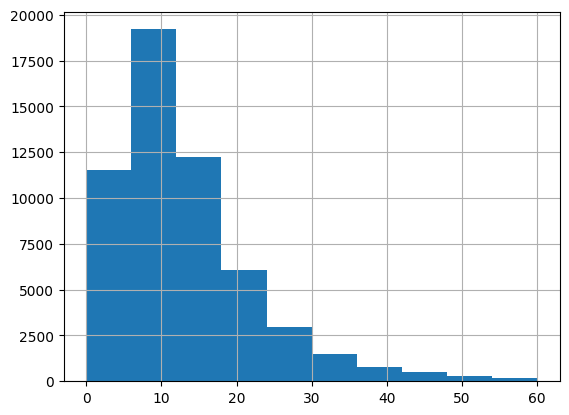

In [8]:
jan_data.duration_min.hist()

In [9]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [10]:
jan_data.shape

(55211, 21)

In [11]:
train_data = jan_data[:30000]
val_data = jan_data[30000:]

In [12]:
model = LinearRegression()

In [13]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [14]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [15]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [16]:
# caluclate mean square error
print(f"{mean_absolute_error(train_data.duration_min, train_data.prediction)} minutes")
print(f"{mean_absolute_error(val_data.duration_min, val_data.prediction)} minutes")

3.804665373785064 minutes
4.14206407368845 minutes


## Dump Model and Reference Data

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [18]:
val_data.to_parquet('data/reference.parquet')

## Evidently Report

In [20]:
column_mapping = ColumnMapping(
    target=None,
    prediction="prediction",
    numerical_features = num_features,
    categorical_features = cat_features
   
)

In [21]:
report = Report(metrics=[
    ColumnDriftMetric(column_name='prediction'),
    DatasetDriftMetric(),
    DatasetMissingValuesMetric()
]
)

In [22]:
report.run(reference_data=train_data, current_data=val_data, column_mapping=column_mapping)

In [23]:
report.show(mode='inline')

In [24]:
result = report.as_dict()

In [25]:
result

{'metrics': [{'metric': 'ColumnDriftMetric',
   'result': {'column_name': 'prediction',
    'column_type': 'num',
    'stattest_name': 'Wasserstein distance (normed)',
    'stattest_threshold': 0.1,
    'drift_score': 0.03049316466166383,
    'drift_detected': False}},
  {'metric': 'DatasetDriftMetric',
   'result': {'drift_share': 0.5,
    'number_of_columns': 7,
    'number_of_drifted_columns': 0,
    'share_of_drifted_columns': 0.0,
    'dataset_drift': False}},
  {'metric': 'DatasetMissingValuesMetric',
   'result': {'different_missing_values': {'': 0,
     -inf: 0,
     None: 25211,
     inf: 0},
    'number_of_different_missing_values': 1,
    'different_missing_values_by_column': {'VendorID': {'': 0,
      -inf: 0,
      None: 0,
      inf: 0},
     'lpep_pickup_datetime': {'': 0, -inf: 0, None: 0, inf: 0},
     'lpep_dropoff_datetime': {'': 0, -inf: 0, None: 0, inf: 0},
     'store_and_fwd_flag': {'': 0, -inf: 0, None: 0, inf: 0},
     'RatecodeID': {'': 0, -inf: 0, None: 0, in

In [26]:
#prediction drift
result['metrics'][0]['result']['drift_score']

0.03049316466166383

In [27]:
#number of drifted columns
result['metrics'][1]['result']['number_of_drifted_columns']

0

In [29]:
#share of missing values
result['metrics'][2]['result']['share_of_missing_values']

0.045454545454545456